# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 2.1

In [25]:
from config import *

# This is needed to render the plots in this chapter
from plots.chapter2_1 import *

In [26]:
import numpy as np
import datetime

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Going Classy

### Introduction

In this chapter, we will:

- Define a class to handle model training.
- Implement the **constructor** method.
- Understand the difference between **public**, **protected**, and **private** methods of a class.
- Integrate the code we have developed so far into our class.
- Instantiate our class, and use it to run a classy pipeline.

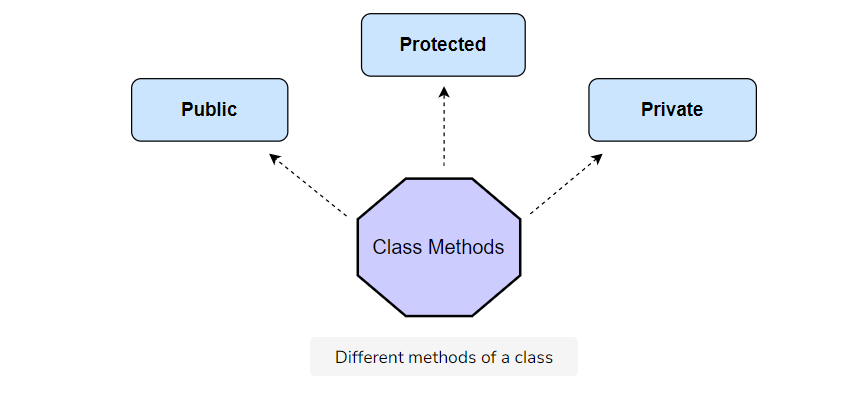

## The Class

Let us start defining our class with a rather unoriginal name: StepByStep. Since we are starting it from scratch, either we do not specify a parent class or we inherit it from the fundamental object class. I prefer the latter, so our class definition looks like this:

In [27]:
# A completely empty (and useless) class
class StepByStep(object):
    pass

## The Constructor

The constructor defines the parts that make up the class. These parts are the attributes of the class. Typical, attributes include:

- **Arguments** provided by the user.

- **Placeholders** for other objects that are not available at the moment of creation (pretty much like delayed arguments).

- **Variables** we may want to keep track of.

- **Functions** that are dynamically built using some of the arguments and higher-order functions.

Let us see how each one of those applies to our problem.

### Arguments

Let us start with the arguments, the part that needs to be specified by the user. At the beginning of the chapter, Rethinking the Training Loop, we asked ourselves: “Would the code inside the training loop change if we were using a different optimizer, loss, or even model?” The answer was and still is no, it would not change.

So, these three elements of optimizer, loss, and model will be our main arguments. The user needs to specify these; we cannot figure them on our own.

But there is one more piece of information needed; the device to be used for training the model. Instead of asking the user to inform it, we will automatically check if there is a GPU available and fall back to a CPU if there is not. But we still want to give the user a chance to use a different device, thus, we add a very simple method named to that allows the user to specify a device.

After adding all our arguments, our constructor (__init__) method will initially look like this:

In [28]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        
    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

### Placeholders

Next, let us tackle the placeholders or delayed arguments. We expect the user to eventually provide some of these, as they are not necessarily required. In our class, there are another three elements that fall into this category: train and validation data loaders and a summary writer to interface with TensorBoard.

The constructor with the appended code will look like the following:

In [29]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        
        # PLACEHOLDERS
        # These attributes are defined here, but since they are
        # not available at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader 
        # (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to create a SummaryWriter to 
        # interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

### Variables

Then, there are variables we may want to track. Typical examples are the number of epochs and the training and validation losses. These variables are likely to be computed and updated internally by the class.

The constructor with the appended code will look like the following, similar to what we did with the placeholders:

In [30]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        
        # PLACEHOLDERS
        # These attributes are defined here, but since they are
        # not available at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # VARIABLES
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader 
        # (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to create a SummaryWriter to 
        # interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

### Functions

For convenience, sometimes it is useful to create attributes that are functions, which will be called somewhere else inside the class. In our case, we can create both `train_step` and `val_step` by using the higher-order functions we defined in the chapter, Rethinking the Training Loop (helper functions #1 and #3, respectively). Both of them take a model, a loss function, and an optimizer as arguments, and all of those are already known attributes of our StepByStep class at construction time.

The code below will be the final updated version of our constructor method:

In [31]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        
        # These attributes are defined here, but since they are
        # not available at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step = self._make_train_step()
        # Creates the val_step function for our model and loss
        self.val_step = self._make_val_step()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader 
        # (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to create a SummaryWriter to 
        # interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

### Step Methods

As you might have noticed, the `_make_train_step` and `_make_val_step` functions are still missing from our StepByStep class.

Using the helper functions #1 and #3 which we had defined in the chapter, Rethinking the Training Loop and using the class attributes, self.model, self.loss_fn, and self.optimizer, these look like this now:

In [32]:
def _make_train_step_fn(self):
    # This method does not need ARGS... it can refer to
    # the attributes: self.model, self.loss_fn and self.optimizer

    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to TRAIN mode
        self.model.train()

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = self.model(x)
        # Step 2 - Computes the loss
        loss = self.loss_fn(yhat, y)
        # Step 3 - Computes gradients for both "b" and "w" parameters
        loss.backward()
        # Step 4 - Updates parameters using gradients and the
        # learning rate
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    # Returns the function that will be called inside the train loop
    return perform_train_step_fn

def _make_val_step_fn(self):
    # Builds function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        self.model.eval()

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = self.model(x)
        # Step 2 - Computes the loss
        loss = self.loss_fn(yhat, y)
        # There is no need to compute Steps 3 and 4, 
        # since we don't update parameters during evaluation
        return loss.item()

    return perform_val_step_fn

## !
To make the additions to our code visually simpler, that is, without having to replicate the full class every time a new method is introduced, I am resorting to something that should not be used in regular circumstances: setattr.

In [33]:
# ATTENTION! Using SETATTR for educational purposes only :-)
setattr(StepByStep, '_make_train_step_fn', _make_train_step_fn)
setattr(StepByStep, '_make_val_step_fn', _make_val_step_fn)

### setattr

The setattr function sets the value of the specified attribute of a given object. But methods are also attributes, so we can use this function to “attach” a method to an existing class and all its existing instances in one go!

Yes, this is a hack! No, you should not use it in your regular code! Using setattr to build a class by appending methods to it incrementally serves educational purposes only.

To illustrate how it works and why it may be dangerous, a small example will be presented to you. Let us create a simple Dog class, which takes only the dog’s name as an argument:

In [34]:
class Dog(object):
    def __init__(self, name):
        self.name = name

Next, let us instantiate our class; that is, we are creating a dog. Let us call it Rex. Its name is going to be stored in the name attribute:

In [35]:
rex = Dog('Rex')
print(rex.name)

Rex


Then, let us create a bark function that takes an instance of Dog as an argument, and call this function to make Rex bark:

In [36]:
def bark(dog):
    print('{} barks: "Woof!"'.format(dog.name))

But that is not what we want. We want our dogs to be able to bark out-of-the-box! So we will use setattr to give dogs the ability to bark. There is one thing we need to change though, and that is the function’s argument. Since we want the bark function to be a method of the Dog class itself, the argument needs to be the method’s own instance: self.

In [37]:
bark(rex)

Rex barks: "Woof!"


In [38]:
def bark(self):
    print('{} barks: "Woof!"'.format(self.name))

setattr(Dog, 'bark', bark)

In [39]:
fido = Dog('Fido')
fido.bark()

Fido barks: "Woof!"


In [40]:
rex.bark()

Rex barks: "Woof!"


## Training Methods

### Mini-Batch

The next method we need is to add corresponds to the helper function #2 in the chapter, Rethinking the Training Loop: the mini-batch loop. We need to modify it a bit before incorporating it in our StepByStep class.

Inside the previous function, both the data loader and the step function were arguments. However, this is not the case anymore since we have both of them as attributes: self.train_loader and self.train_step for training; self.val_loader and self.val_step for validation. The only thing this method needs to know is if it is handling training or validation data. The updated code should look like this:

In [41]:
def _mini_batch(self, validation=False):
    # The mini-batch can be used with both loaders
    # The argument `validation`defines which loader and 
    # corresponding step function is going to be used
    if validation:
        data_loader = self.val_loader
        step_fn = self.val_step_fn
    else:
        data_loader = self.train_loader
        step_fn = self.train_step_fn

    if data_loader is None:
        return None

    # Once the data loader and step function, this is the same
    # mini-batch loop we had before
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)

    return loss

setattr(StepByStep, '_mini_batch', _mini_batch)

Moreover, if the user decides not to provide a validation loader, it will retain its initial None value from the constructor method. If that is the case, we do not have a corresponding loss to compute, and it returns None instead (line 13 in the snippet above).

### Training Loop

What is left to do? The training loop, of course! It will be similar to our model training V5 in the chapter, Rethinking the Training Loop, but we can make it even more flexible, taking the number of epochs and the random seed as arguments.

This solves the issue we faced in the chapter, Rethinking the Training Loop, when we had to train for another 200 epochs after loading a checkpoint just because it was hard-coded into the training loop. Well, not anymore!

Moreover, we need to ensure the reproducibility of the training loop. We have already set up seeds to ensure the reproducibility of the random split (data preparation) and the model initialization (model configuration). So far, we were running the full pipeline in order, so the training loop yielded the same results every time. Now, to gain flexibility without compromising reproducibility, we need to set yet another random seed.

We are building a method to take care of seed-setting only, following PyTorch’s guidelines on reproducibility:

In [42]:
def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
setattr(StepByStep, 'set_seed', set_seed)

It is also time to use the variables we defined as attributes in the constructor method: self.total_epochs, self.losses, and self.val_losses. All of them are being updated inside the training loop.

In [43]:
def train(self, n_epochs, seed=42):
    # To ensure reproducibility of the training process
    self.set_seed(seed)
    
    for epoch in range(n_epochs):
        # Keeps track of the numbers of epochs
        # by updating the corresponding attribute
        self.total_epochs += 1

        # inner loop
        # Performs training using mini-batches
        loss = self._mini_batch(validation=False)
        self.losses.append(loss)

        # VALIDATION
        # no gradients in validation!
        with torch.no_grad():
            # Performs evaluation using mini-batches
            val_loss = self._mini_batch(validation=True)
            self.val_losses.append(val_loss)

        # If a SummaryWriter has been set...
        if self.writer:
            scalars = {'training': loss}
            if val_loss is not None:
                scalars.update({'validation': val_loss})
            # Records both losses for each epoch under the main tag "loss"
            self.writer.add_scalars(main_tag='loss',
                                    tag_scalar_dict=scalars,
                                    global_step=epoch)

    if self.writer:
        # Flushes the writer
        self.writer.flush()
        
setattr(StepByStep, 'train', train)

Did you notice this function does not return anything? It does not need to! Instead of returning values, it simply updates several class attributes: self.losses, self.val_losses, and self.total_epochs.

The current state of development of our StepByStep class already allows us to train a model fully. Now, let us give our class the ability to save and load models as well.

## Saving and Loading Methods

### Saving

Most of the code here is the same as the code we had in the chapter, Rethinking the Training Loop. The only difference is that we will be using the class attributes instead of the local variables.

The updated method for saving checkpoints should look like this now:

In [44]:
def save_checkpoint(self, filename):
    # Builds dictionary with all elements for resuming training
    checkpoint = {'epoch': self.total_epochs,
                  'model_state_dict': self.model.state_dict(),
                  'optimizer_state_dict': self.optimizer.state_dict(),
                  'loss': self.losses,
                  'val_loss': self.val_losses}

    torch.save(checkpoint, filename)
    
setattr(StepByStep, 'save_checkpoint', save_checkpoint)

### Loading

In addition, the loading checkpoint method should look like the following:

In [45]:
def load_checkpoint(self, filename):
    # Loads dictionary
    checkpoint = torch.load(filename)

    # Restore state for model and optimizer
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    self.total_epochs = checkpoint['epoch']
    self.losses = checkpoint['loss']
    self.val_losses = checkpoint['val_loss']

    self.model.train() # always use TRAIN for resuming training   
    
setattr(StepByStep, 'load_checkpoint', load_checkpoint)

### Making Predictions

What about making predictions? To make it easier for the user to make predictions for any new data points, we will be handling all the Numpy to PyTorch back and forth conversion inside this function:

In [46]:
def predict(self, x):
    # Set is to evaluation mode for predictions
    self.model.eval() 
    # Takes aNumpy input and make it a float tensor
    x_tensor = torch.as_tensor(x).float()
    # Send input to device and uses model for prediction
    y_hat_tensor = self.model(x_tensor.to(self.device))
    # Set it back to train mode
    self.model.train()
    # Detaches it, brings it to CPU and back to Numpy
    return y_hat_tensor.detach().cpu().numpy()

setattr(StepByStep, 'predict', predict)

## Visualization Methods

### Losses

Since we have kept track of both the training and validation losses as attributes, let us build a simple plot function for them, which looks like the following:

In [47]:
def plot_losses(self):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(self.losses, label='Training Loss', c='b')
    if self.val_loader:
        plt.plot(self.val_losses, label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

setattr(StepByStep, 'plot_losses', plot_losses)

### Model Graph

Finally, if both the training loader and TensorBoard were already configured, we can use the former to fetch a single mini-batch and the latter to build the model graph in TensorBoard:

In [48]:
def add_graph(self):
    if self.train_loader and self.writer:
        # Fetches a single mini-batch so we can use add_graph
        x_sample, y_sample = next(iter(self.train_loader))
        self.writer.add_graph(self.model, x_sample.to(self.device))
    
setattr(StepByStep, 'add_graph', add_graph)

## The Full Code

Combining all the coding snippets that we have discussed so far, you can find the complete code of the StepByStep class below:

In [49]:
# %load stepbystep/v0.py

import numpy as np
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

plt.style.use('fivethirtyeight')

class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn
    
    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, 
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn
            
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None
            
        # Once the data loader and step function, this is the 
        # same mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))


## Classy Pipeline

In the chapter, Rethinking the Training Loop, our pipeline was composed of three steps: data preparation V2, model configuration V3, and model training V5. The last step, model training, has already been integrated into our StepByStep class. Let us take a look at the other two steps:

But before that, let us generate our synthetic data once again.

### Data Generation

In [50]:
# Runs data generation - so we do not need to copy code here
%run -i Scripts/data_generation/simple_linear_regression.py

<Figure size 432x288 with 0 Axes>

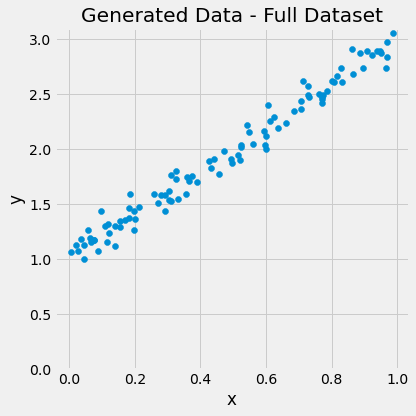

In [51]:
fig = figure1(x, y)

### Data Preparation V2

The first part of the pipeline is the data preparation. It turns out; we can still keep it exactly the way it was.

In [52]:
# %load data_preparation/v2.py
torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

### Model Configuration V4

Next in line is the model configuration. Some of its code has already been integrated into our class: both the train_step and val_step functions, the SummaryWriter, and adding the model graph.

So, we strip the model configuration code down to its bare minimum; that is, we keep only the elements we need to pass as arguments to our StepByStep class: model, loss function, and optimizer.

In [54]:
%%writefile Scripts/model_configuration/v4.py

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1))

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

Writing Scripts/model_configuration/v4.py


In [56]:
%run -i Scripts/model_configuration/v4.py

<Figure size 432x288 with 0 Axes>

In [57]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])


## Model training

#### Starting steps

We start by instantiating the StepByStep class with the corresponding arguments. Next, we set its loaders using the 
appropriately named function set_loaders. Then, we set up an interface with TensorBoard, and then name our experiment “classy.”

In [58]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')

One important thing to notice is that the model attribute of the sbs object is the same object as the model variable created in the model configuration. It is not a copy! We can easily verify this:

In [59]:
print(sbs.model == model)
print(sbs.model)

True
Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


### Training the model

Let us train the model now by using the same 200 epochs as before. Check this out:

In [60]:
sbs.train(n_epochs=200)

In [61]:
print(model.state_dict()) # remember, model == sbs.model
print(sbs.total_epochs)

OrderedDict([('0.weight', tensor([[1.9416]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])
200


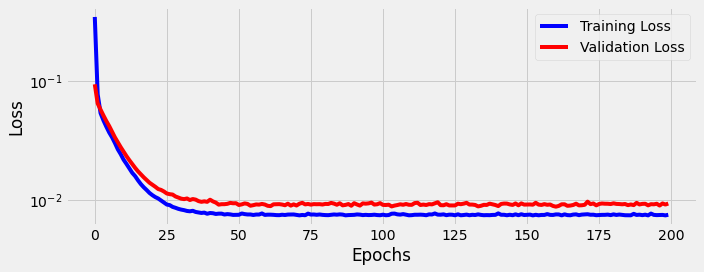

In [62]:
fig = sbs.plot_losses()

### Making Predictions

Let us make up some data points for our feature x, and shape them as a single-column matrix:

In [63]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)
new_data

array([[0.5],
       [0.3],
       [0.7]])

Since the Numpy array to PyTorch tensor conversion is already handled by the predict method, we can call the method right away, passing the array as its argument:

In [64]:
predictions = sbs.predict(new_data)
predictions

array([[1.9942763],
       [1.605955 ],
       [2.3825977]], dtype=float32)

### Checkpointing

### Saving checkpoints

To checkpoint the model to resume training later, we can use the save_checkpoint method, which handles the state dictionaries for us and saves them to a file:

In [65]:
sbs.save_checkpoint('model_checkpoint.pth')

### Resuming Training

Remember, when we did this in the chapter, Rethinking the Training Loop, we had to set up the stage before actually loading the model, loading the data, and configuring the model. We still need to do this, but we are now using the latest version of the model configuration section:

In [68]:
%run -i Scripts/model_configuration/v4.py

<Figure size 432x288 with 0 Axes>

In [69]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])


Good. Same as before! Besides, the model configuration part has created the three elements we need to pass as arguments to instantiate our StepByStep class:

In [70]:
new_sbs = StepByStep(model, loss_fn, optimizer)

Next, let us load the trained model back by using the load_checkpoint method, and inspect the model’s weights:

In [71]:
new_sbs.load_checkpoint('model_checkpoint.pth')
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9416]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


Great, these are the weights of our trained model. Let us train it a bit further then.

In the chapter, Rethinking the Training Loop, we could only train it for another 200 epochs since the number of epochs was hard-coded. However, due to our StepByStep class, we now have the flexibility to train the model for as many epochs as we please.

But we are still missing one thing: the data! First, we need to set the data loader(s), and then we can train our model for another, say, 50 epochs.

In [72]:
new_sbs.set_loaders(train_loader, val_loader)
new_sbs.train(n_epochs=50)

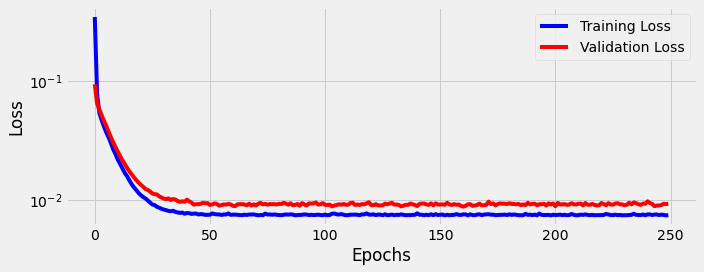

In [73]:
fig = new_sbs.plot_losses()

In [74]:
print(sbs.model.state_dict())

OrderedDict([('0.weight', tensor([[1.9416]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


# Putting It All Together

### Data preparation V2

The data preparation part was kept exactly the same way as it was before, which can be seen below:

In [77]:
# %load data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_data,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(dataset=val_data, batch_size=16)

### Model configuration V4

In the model configuration code, we stripped off the train_step and val_step functions, the SummaryWriter, and the model graph and only kept the elements we needed to pass as arguments to our StepByStep class: model, loss function, and optimizer.

In [78]:
# %load model_configuration/v4.py

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model
model = nn.Sequential(nn.Linear(1, 1))

# Defines a SGD optimizer to update the parameters 
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

### Model training

In model training, we began by instantiating the StepByStep class with the corresponding arguments. Next, we set up its loaders using the appropriately named function set_loaders. Then, we set up an interface with TensorBoard and named our experiment classy. We then trained the model using the epochs that we had set:

In [79]:
n_epochs = 200

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')
sbs.train(n_epochs=n_epochs)

In [80]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9416]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])
